# Quality Control and ASV table construction with DADA2

## Setup and settings

In [1]:
# Importing packages
import os
import yaml
import logging
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
import qiime2.plugins.dada2.actions as dada2_actions
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.feature_table.visualizers import tabulate_seqs
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.feature_table.visualizers import core_features
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs

import matplotlib.pyplot as plt

%matplotlib inline

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [2]:
experiment_name = 'ana-flavia-superlactacao'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'redemicro')
metadata_file = os.path.join(base_dir, 'data', 'raw', 'metadata', 'sample-metadata.tsv')
manifest_file = os.path.join(base_dir, 'data', 'raw', 'manifest', 'sample-manifest.csv')
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = None

In [3]:
# Parameters
base_dir = "/mnt/nupeb/rede-micro/redemicro-ana-flavia-nutri"
class_col = "group-id"
classifier_file = "/mnt/nupeb/rede-micro/datasets/16S_classifiers_qiime2/silva-138-99-nb-classifier.qza"
experiment_name = "ana-flavia-NCxHSD-NC-trim"
manifest_file = "/mnt/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/manifest/manifest-ana-flavia-NCxHSD-NC.csv"
metadata_file = "/mnt/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/metadata/metadata-ana-flavia-NCxHSD-NC.tsv"
overlap = 12
phred = 20
replace_files = False
threads = 6
top_n = 20
trim = {
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "overlap": 8,
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}
trunc_f = 0
trunc_r = 0


In [4]:
# Setting hardcoded parameters for development and debbuging
production = True
if not production:
    params_path = os.path.join('..', 'params', 'ana-flavia-superlactacao.yaml')
    with open(params_path, 'r') as stream:
        params = yaml.safe_load(stream)
        experiment_name = params['experiment_name']
        base_dir = params['base_dir']
        replace_files = params['replace_files']
        experiment_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'experiments', 'thayane-feces-01'))
        img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
        replace_files = False
        phred = 20
        trunc_f = 0
        trunc_r = 0
        overlap = 12
        threads = 6

In [5]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')
data_dir =  os.path.abspath(os.path.join(base_dir, 'data'))
raw_data_dir =  os.path.abspath(os.path.join(data_dir, 'raw'))
interim_data_dir =  os.path.abspath(os.path.join(data_dir, 'interim'))

### Defining names and paths

In [6]:
# Determine if is SingleEnd or PairedEnd
manifest_df = pd.read_csv(manifest_file)
n_directions = len(manifest_df['direction'].unique())
sufix = 'single' if n_directions == 1 else 'paired'

In [7]:
if trim:
    demux_file = os.path.join(qiime_folder, f'demux-{sufix}-trim.qza')
else:
    demux_file = os.path.join(qiime_folder, f'demux-{sufix}.qza')

dada2_tabs = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat = os.path.join(qiime_folder, 'dada2-stat.qza')


dada2_tabs_view = dada2_tabs[:-1] + 'v'
dada2_reps_view = dada2_reps[:-1] + 'v'
dada2_stat_view = dada2_stat[:-1] + 'v'
dada2_core_view = os.path.join(qiime_folder, 'dada2-core.qzv')

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [8]:
need_dada2 = not (os.path.isfile(dada2_tabs) and os.path.isfile(dada2_reps) and os.path.isfile(dada2_stat)) or replace_files
need_view = not (os.path.isfile(dada2_tabs_view) and os.path.isfile(dada2_reps_view) and os.path.isfile(dada2_stat_view)) or replace_files

In [9]:
if need_dada2:
    demux = Artifact.load(demux_file)

In [10]:
metadata = Metadata.load(metadata_file)

### Execute DADA2 plugin and create Artifacts

The DADA2 plugin perform tha quality control and create the ASV table. It will be produced three Artifacts:

- tabs (`FeatureTable[Frequency]`) : 
    The resulting feature table.
- reps (`FeatureData[Sequence]`) :
    The resulting feature sequences. Each feature in the feature table will
    be represented by exactly one sequence, and these sequences will be the
    joined paired-end sequences.
- denoising_stats (`SampleData[DADA2Stats]`) : the resulting stats. Shows the number and the proportion of filtered reads in each phase of the plugin execution.

In [11]:
if not os.path.isfile(dada2_tabs) or replace_files:
    interim_tabs_path = os.path.join(interim_data_dir, "dada2-tabs.qza")
    interim_reps_path = os.path.join(interim_data_dir, "dada2-reps.qza")
    interim_stat_path = os.path.join(interim_data_dir, "dada2-stat.qza")
    # Verify if has shared files
    if os.path.isfile(interim_tabs_path) and os.path.isfile(interim_reps_path) and os.path.isfile(interim_stat_path):
        print("Load DADA2 data from shared files")
        tabs = Artifact.load(interim_tabs_path)
        reps = Artifact.load(interim_reps_path)
        stat = Artifact.load(interim_stat_path)
    # Create new DADA2 files
    else:
        print("Create new local DADA2 data")
        if n_directions == 1: # SingleEnd
            tabs, reps, stat = dada2_actions.denoise_single(
                demultiplexed_seqs=demux,
                trunc_q = phred,
                n_threads = threads,
                trunc_len = trunc_f,
            )
        elif n_directions == 2: # PairedEnd
            tabs, reps, stat = dada2_actions.denoise_paired(
                demultiplexed_seqs=demux,
                trunc_q = phred,
                min_overlap = overlap,
                n_threads = threads,
                trunc_len_f = trunc_f,
                trunc_len_r = trunc_r,
            )
        tabs.save(dada2_tabs)
        reps.save(dada2_reps)
        stat.save(dada2_stat)
else:
    print("Load DADA2 data from local files")
    tabs = Artifact.load(dada2_tabs)
    reps = Artifact.load(dada2_reps)
    stat = Artifact.load(dada2_stat)

Create new local DADA2 data
Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada.R --input_directory /tmp/tmpjdwlcolc/forward --input_directory_reverse /tmp/tmpjdwlcolc/reverse --output_path /tmp/tmpjdwlcolc/output.tsv.biom --output_track /tmp/tmpjdwlcolc/track.tsv --filtered_directory /tmp/tmpjdwlcolc/filt_f --filtered_directory_reverse /tmp/tmpjdwlcolc/filt_r --truncation_length 0 --truncation_length_reverse 0 --trim_left 0 --trim_left_reverse 0 --max_expected_errors 2.0 --max_expected_errors_reverse 2.0 --truncation_quality_score 20 --min_overlap 12 --pooling_method independent --chimera_method consensus --min_parental_fold 1.0 --allow_one_off False --num_threads 6 --learn_min_reads 1000000

R version 4.2.3 (2023-03-15) 


Loading required package: Rcpp


DADA2: 1.26.0 / Rcpp: 1.0.10 / RcppParallel: 5.1.6 
2) Filtering 

............
3) Learning Error Rates


365445471 total bases in 1554035 reads from 4 samples will be used for learning the error rates.


239863949 total bases in 1554035 reads from 4 samples will be used for learning the error rates.


3) Denoise samples 

.

.

.

.

.

.

.

.

.

.

.

.


.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

Duplicate sequences in merged output.


.

.

Duplicate sequences in merged output.


.

.

Duplicate sequences in merged output.


.

.

..
5) Remove chimeras (method = consensus)


Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.
Duplicate sequences detected and merged.


6) Report read numbers through the pipeline
7) Write output


### Filter samples

In [12]:
# Filter FeatureTable[Frequency | RelativeFrequency | PresenceAbsence | Composition] based on Metadata sample ID values
tabs = filter_samples(
    table=tabs,
    metadata=metadata,
).filtered_table
# Filter SampleData[SequencesWithQuality | PairedEndSequencesWithQuality | JoinedSequencesWithQuality] based on Metadata sample ID values; returns FeatureData[Sequence | AlignedSequence]
reps = filter_seqs(
    data=reps,
    table=tabs,
).filtered_data

/home/lauro/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/q2_types/feature_data/_transformer.py:258: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id_, seq in data.iteritems():


### Define Visualizations Artifacts

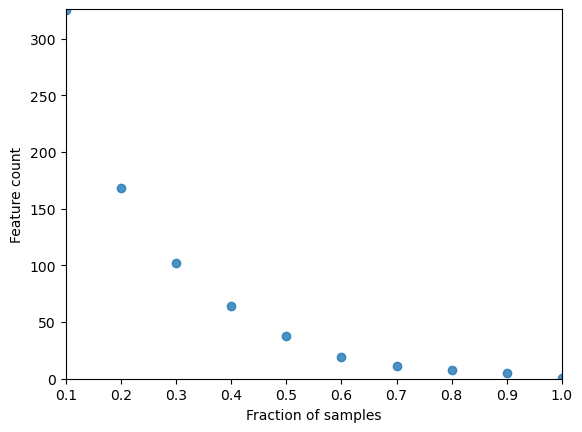

In [13]:
# If some of the DADA2 Visualization artifacts do not exist or if the old files will be replaced
if need_view:
    
    tabs_view, = metadata_actions.tabulate(input=tabs.view(Metadata))
    reps_view, = metadata_actions.tabulate(input=reps.view(Metadata))
    stat_view, = metadata_actions.tabulate(input=stat.view(Metadata))
    
    tabs_view = summarize(table=tabs, sample_metadata=metadata).visualization
    reps_view = tabulate_seqs(data=reps).visualization
    core_view = core_features(table=tabs, min_fraction=.1, steps=10).visualization
    
    
    # Save the artifacts objects
    tabs_view.save(dada2_tabs_view)
    reps_view.save(dada2_reps_view)
    stat_view.save(dada2_stat_view)
    core_view.save(dada2_core_view)

else:
    tabs_view = Visualization.load(dada2_tabs_view)
    reps_view = Visualization.load(dada2_reps_view)
    stat_view = Visualization.load(dada2_stat_view)
    core_view = Visualization.load(dada2_core_view)

In [14]:
def plot_stats_box(artifact, fname, total_reads_phases, percent_phases, cols):
    import matplotlib.pyplot as plt
    from qiime2 import Metadata
    
    df = artifact.view(Metadata).to_dataframe()
    df_vals = df[total_reads_phases]
    df_perc = df[percent_phases]
    df_perc.columns = cols
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    df_vals.boxplot()
    plt.xlabel('Fases')
    plt.ylabel('# of reads')
    
    plt.subplot(1, 2, 2)
    df_perc.boxplot()
    plt.xlabel('Fases')
    plt.ylabel('% of input')
    
    plt.savefig(fname, bbox_inches='tight')

    plt.show()

In [15]:
if n_directions == 1: # SingleEnd
    total_reads_phases = ['input', 'filtered', 'denoised', 'non-chimeric']
    percent_phases = ['percentage of input passed filter', 'percentage of input non-chimeric']
    cols = ['filtered', 'non-chimeric']
elif n_directions == 2: # PairedEnd
    total_reads_phases = ['input', 'filtered', 'denoised', 'merged', 'non-chimeric']
    percent_phases = ['percentage of input passed filter', 'percentage of input merged', 'percentage of input non-chimeric']
    cols = ['filtered', 'merged', 'non-chimeric']

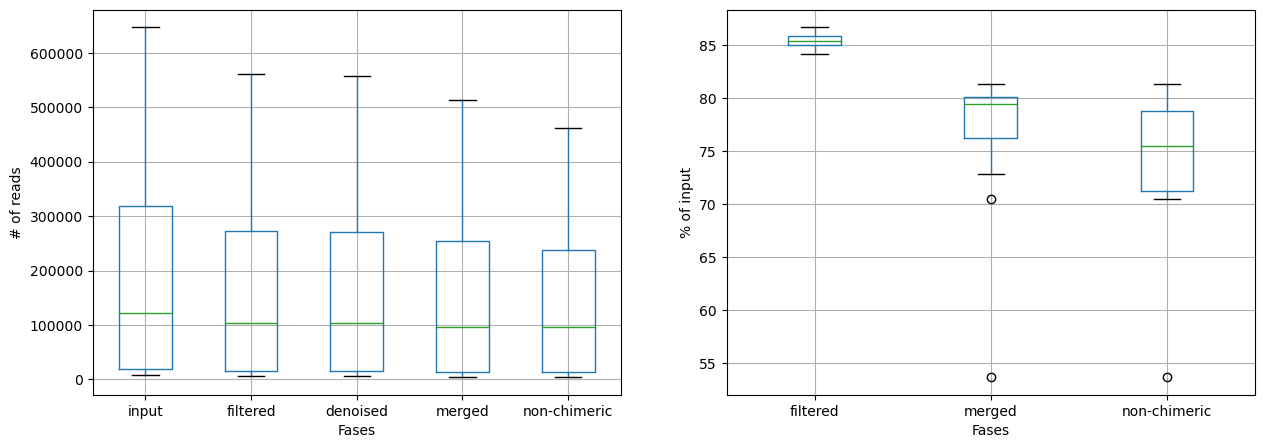

In [16]:
plot_stats_box(stat, os.path.join(img_folder, 'step02-stats-boxplot.pdf'), total_reads_phases, percent_phases, cols)

In [17]:
stat.view(Metadata).to_dataframe().describe()[percent_phases]

,percentage of input passed filter,percentage of input merged,percentage of input non-chimeric
count,12.0000,12.000000,12.000000
mean,85.4250,76.195833,73.948333
std,0.7300,7.848019,7.483717
min,84.1700,53.650000,53.650000
25%,84.9650,76.235000,71.212500
50%,85.3200,79.465000,75.435000
75%,85.8425,80.095000,78.740000
max,86.6600,81.330000,81.320000


In [18]:
stat_view

<visualization: Visualization uuid: 1e6425b0-645a-4e25-aab9-a87fed4af20e>